In [156]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.onnx
import torch.optim as optim
import numpy as np
from scipy.signal import butter, lfilter, sosfilt, sosfreqz
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm

# Some basic Visualization

In [145]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = 22050/2):
    return_signal = np.zeros((8, 2205))
    return_signal[0] = raw_signal
    
    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    
    return return_signal

In [146]:
X = np.load('Bee-Audio_X.npy')
Y = np.load('Bee_Audio_Y.npy')

filtered_signal = make_signal(X[1])
filtered_signal.shape

(8, 2205)

In [217]:
X.shape

(27048, 2205)

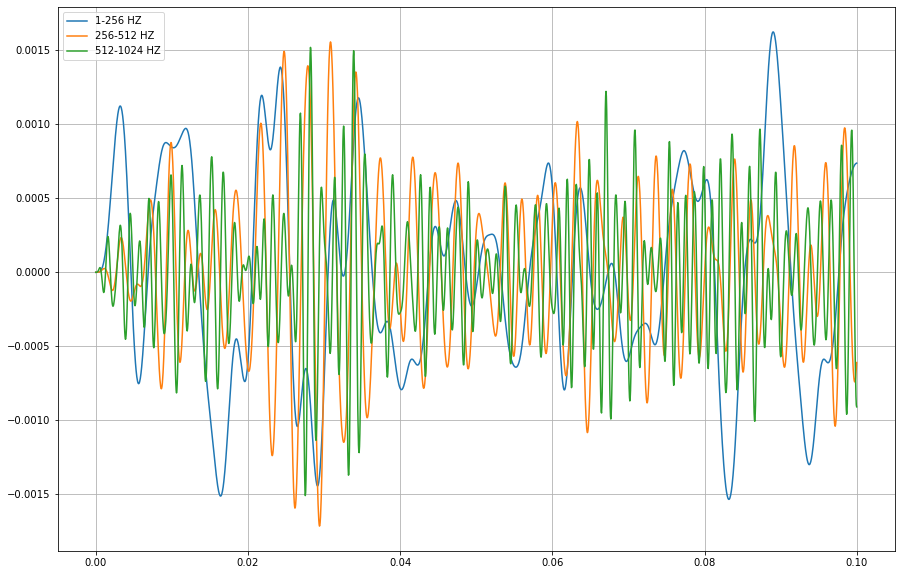

In [147]:
T = 2205/22050
t = np.linspace(0, T, 2205, endpoint = False)

plt.figure(figsize=(15,10))
#plt.plot(t, X[1], label='Raw Signal')
plt.plot(t, filtered_signal[1], label = '1-256 HZ')
plt.plot(t, filtered_signal[2], label = '256-512 HZ')
plt.plot(t, filtered_signal[3], label = '512-1024 HZ')
#plt.plot(t, filtered_signal[4], label = '1024-2048 HZ')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

# Load Data

In [153]:
class BeeDataset(torch.utils.data.Dataset):
    def __init__(self, x_path, y_path, train=True, split=0.7, seed=14):
        self.X = np.load(x_path)
        self.Y = np.load(y_path)
        np.random.RandomState(seed)
        shuffletwo(self.X, self.Y)
        instances = int(len(self.Y)*split)
        
        if train:
            self.X, self.Y = self.X[:instances], self.Y[:instances]
        else:
            self.X, self.Y = self.X[instances:], self.Y[instances:]
        
    def __getitem__(self, idx):
        return make_signal(self.X[idx]), self.Y[idx]
    
    
    def __len__(self):
        return len(self.Y)
    
    def bandpass_filter(signal, low, high, order = 5):
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        y = sosfilt(sos, signal)
        return y
    
    def make_signal(raw_signal, nyq = 22050/2):
        return_signal = np.zeros((8, 2205))
        return_signal[0] = raw_signal

        cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
        for i in range(1, len(cut_offs), 1):
            return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])

        return return_signal
        
    
    def shuffletwo(x, y):
        rng_state = np.random.get_state()
        np.random.shuffle(x)
        np.random.set_state(rng_state)
        np.random.shuffle(y)
        

In [213]:
Bee_Data = BeeDataset('Bee-Audio_X.npy', 'Bee_Audio_Y.npy')
Bee_Test_Data = BeeDataset('Bee-Audio_X.npy', 'Bee_Audio_Y.npy', train=False)
Bee_Dataloader = DataLoader(Bee_Data, batch_size=32, shuffle = True)
Bee_Test_Dataloader = DataLoader(Bee_Test_Data, batch_size=32, shuffle = True)

# Create Model

In [207]:
class Cough_Sense(torch.nn.Module):
    
    def __init__(self):
        super(Cough_Sense, self).__init__()
        self.input_layer = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=32, stride=8, padding=True)
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.cnn_16_16_5 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=16, stride=4, padding=True)
        self.cnn_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding=True)
        self.fci = nn.Linear(in_features=384, out_features=16)
        self.fco = nn.Linear(in_features=16, out_features=1)
        self.out = nn.Sigmoid()
        
    def forward(self, x):
        #print(x.shape)
        x = self.input_layer(x)
        x = self.relu(x)
        
        #print(x.shape)
        x = self.cnn_16_16_5(x)
        x = self.relu(x)
        
        #print(x.shape)
        x = self.cnn_16_16_5(x)
        x = self.relu(x)
        
        #print(x.shape)
        x = self.cnn_16_32_3(x)
        x = self.relu(x)
        
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        
        #print(x.shape)
        x = self.fci(x)
        x = self.sigm(x)
        
        #print(x.shape)
        x = self.fco(x)
        x = self.out(x)
        
        #print(x.shape)
        return x
    


In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = Cough_Sense()
Model.float()
Model.to(device)
summary(Model, (8, 2205))

criterion = nn.BCELoss()
optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 272]           4,112
              ReLU-2              [-1, 16, 272]               0
            Conv1d-3               [-1, 16, 65]           4,112
              ReLU-4               [-1, 16, 65]               0
            Conv1d-5               [-1, 16, 13]           4,112
              ReLU-6               [-1, 16, 13]               0
            Conv1d-7               [-1, 32, 12]           2,080
              ReLU-8               [-1, 32, 12]               0
            Linear-9                   [-1, 16]           6,160
          Sigmoid-10                   [-1, 16]               0
           Linear-11                    [-1, 1]              17
          Sigmoid-12                    [-1, 1]               0
Total params: 20,593
Trainable params: 20,593
Non-trainable params: 0
---------------------------------

9# Initiate Traning

In [224]:
running_loss=0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in tqdm.tqdm(range(10)):
    i=0
    for data in tqdm.tqdm(Bee_Dataloader):
        inputs, labels = data
        #inputs.double()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        #print(inputs)
        optimizer.zero_grad()

        outputs = Model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        i+=1
        if i%100==0:
            print(running_loss)
            running_loss=0
    

43.32412660121918
45.815137162804604
42.80412782728672
42.61204354465008
45.65183699131012



85.35802009701729
41.95602096617222
43.349026799201965
43.934325501322746
44.2960279583931



86.09793175756931
42.72726292908192
43.7165005505085
44.96546007692814
44.07573316991329



86.12397454679012
43.83044520020485
43.04744613170624
43.19072934985161
44.711702063679695



86.00479324162006
44.243147641420364
42.58269000053406
45.163370579481125
42.89743630588055



84.71349342167377
44.48798622190952
42.83631253242493
44.39435218274593
44.12493899464607



83.7903096228838
44.02606098353863
43.50643962621689
45.066813334822655
42.63331986963749



85.36710794270039
43.2515045106411
44.5947704911232
43.97553649544716
43.257021591067314



84.84859685599804
44.0782515257597
44.49961045384407
43.249044850468636
43.60917471349239



85.52066415548325
45.762688249349594
42.546239882707596
43.13992524147034
44.394395634531975




In [222]:
np.sum(Y.reshape((len(Y)))), (len(Y))

(22693.0, 27048)

# Inference

In [216]:
i=0
for data in Bee_Test_Dataloader:
    inputs, targets = data
    inputs = inputs.float().to(device)
    Outputs = Model(inputs)
    print(Outputs)
    print(targets)
    i+=1
    if i==2:
        break

tensor([[0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336],
        [0.8336]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
 